In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
import anndata
import scanpy as sc


In [2]:
cur_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/data/DIMITRA_FASTQ/"
work_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/"
out_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/out/"
new_out_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/"
plot_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/out/plots/"
##load annotations and plot sankey
data_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/data/"
newdata_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/"
plot_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/"

references = "/well/immune-rep/users/vbw431/reference/reference/refdata-gex-GRCh38-2020-A/"


In [3]:
azimuth = sc.read_h5ad(work_dir +"reference_seurat/pbmc.h5ad")


In [4]:
azimuth.obs["sample_ID"] = azimuth.obs["lane"].astype("str")+"_Azimuth_dataset"
azimuth.obs['nCount_RNA'] = azimuth.obs['nCount_RNA'] - 3000
azimuth.obs['nFeature_RNA'] = azimuth.obs['nFeature_RNA'] - 800
azimuth.obs['nCount_RNA'] = np.maximum(azimuth.obs['nCount_RNA'], 0)
azimuth.obs['nFeature_RNA'] = np.maximum(azimuth.obs['nFeature_RNA'], 0)
azimuth.obs['Ref_lab'] = "Azimuth_Satija_Lab"


In [5]:
##load data 
file_list = []
for file in os.listdir(new_out_dir):
    if file.endswith("pre_QC.h5ad"):
        file_list.append(os.path.join(new_out_dir, file)) 
        
file_list

['/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/HIVHBV_C_peppa10x_full_pre_QC.h5ad',
 '/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/HH_Tre_4_peppa10x_full_pre_QC.h5ad',
 '/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/Healthy_peppa10x_full_pre_QC.h5ad',
 '/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/HBV_Tre_1_peppa10x_full_pre_QC.h5ad',
 '/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/HIVHBV_Tre_5_peppa10x_full_pre_QC.h5ad',
 '/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/HBV_Tre_3_peppa10x_full_pre_QC.h5ad',
 '/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/HBV_X2_peppa10x_full_pre_QC.h5ad',
 '/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/HBV_C_peppa10x_full_pre_QC.h5ad',
 '/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/HIVHBV_X2_peppa10x_full_pre_QC.h5ad',
 '/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/HBV_Tre_2_peppa1

In [6]:
adata_list = []
for file in file_list:
    adata = sc.read_h5ad(file)
    adata.obs['Ref_lab'] = "Peppa"
    adata_list.append(adata)
    

In [7]:
adata_list.append(azimuth)

In [8]:
adata_concat = anndata.concat(adata_list)

/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
set(adata_concat.obs)


{'Phase', 'Ref_lab', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'sample_ID'}

In [10]:
# Identifying mitochondrial genes. This might vary depending on your dataset.
# Typically, mitochondrial genes in humans and mice start with 'MT-'.
mito_genes = adata_concat.var_names.str.startswith('MT-')

# For each cell compute total counts and mitochondrial counts
adata_concat.obs['total_counts'] = adata_concat.X.sum(axis=1)
adata_concat.obs['mito_counts'] = adata_concat[:, mito_genes].X.sum(axis=1)

# Calculate the percentage of mitochondrial genes
adata_concat.obs['percent_mito'] = (adata_concat.obs['mito_counts'] / adata_concat.obs['total_counts']) * 100



In [11]:
ribo_genes = adata_concat.var_names.str.startswith(('RPS', 'RPL'))

# For each cell compute total counts and ribosomal counts
adata_concat.obs['total_counts'] = adata_concat.X.sum(axis=1)
adata_concat.obs['ribo_counts'] = adata_concat[:, ribo_genes].X.sum(axis=1)

# Calculate the percentage of ribosomal genes
adata_concat.obs['percent_ribo'] = (adata_concat.obs['ribo_counts'] / adata_concat.obs['total_counts']) * 100

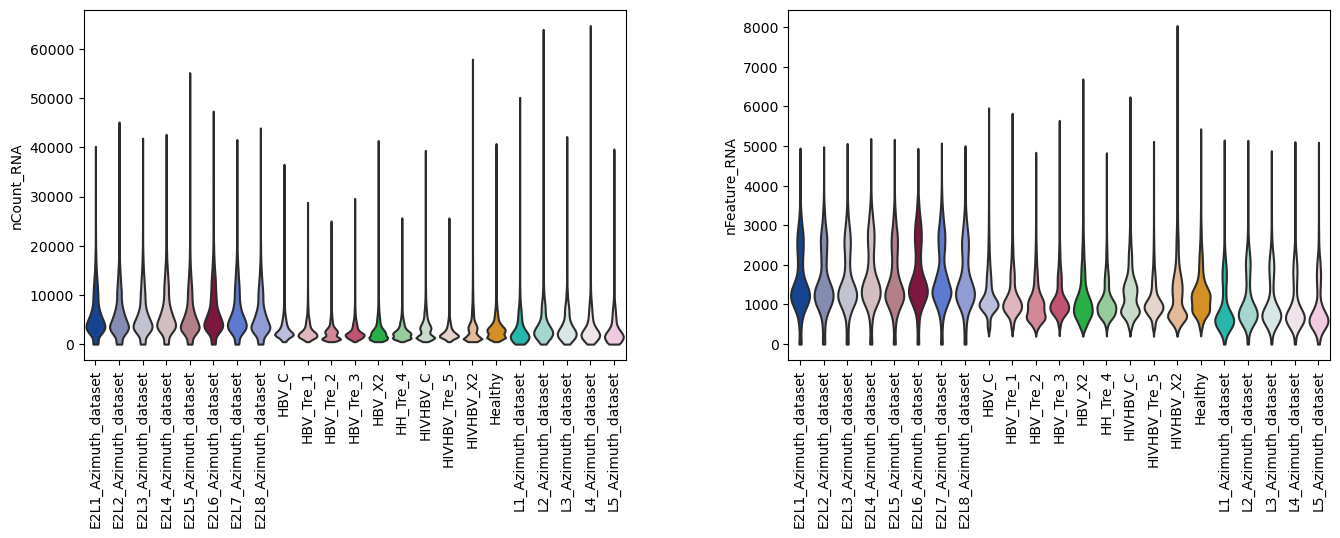

In [12]:
sc.pl.violin(adata_concat, ['nCount_RNA', 'nFeature_RNA'],groupby='sample_ID',
               stripplot=False,multi_panel=True, rotation=90, ncol=1)

In [13]:
sc.pl.scatter(adata_concat, x='percent_ribo', y='percent_mito', size=3, color="sample_ID")


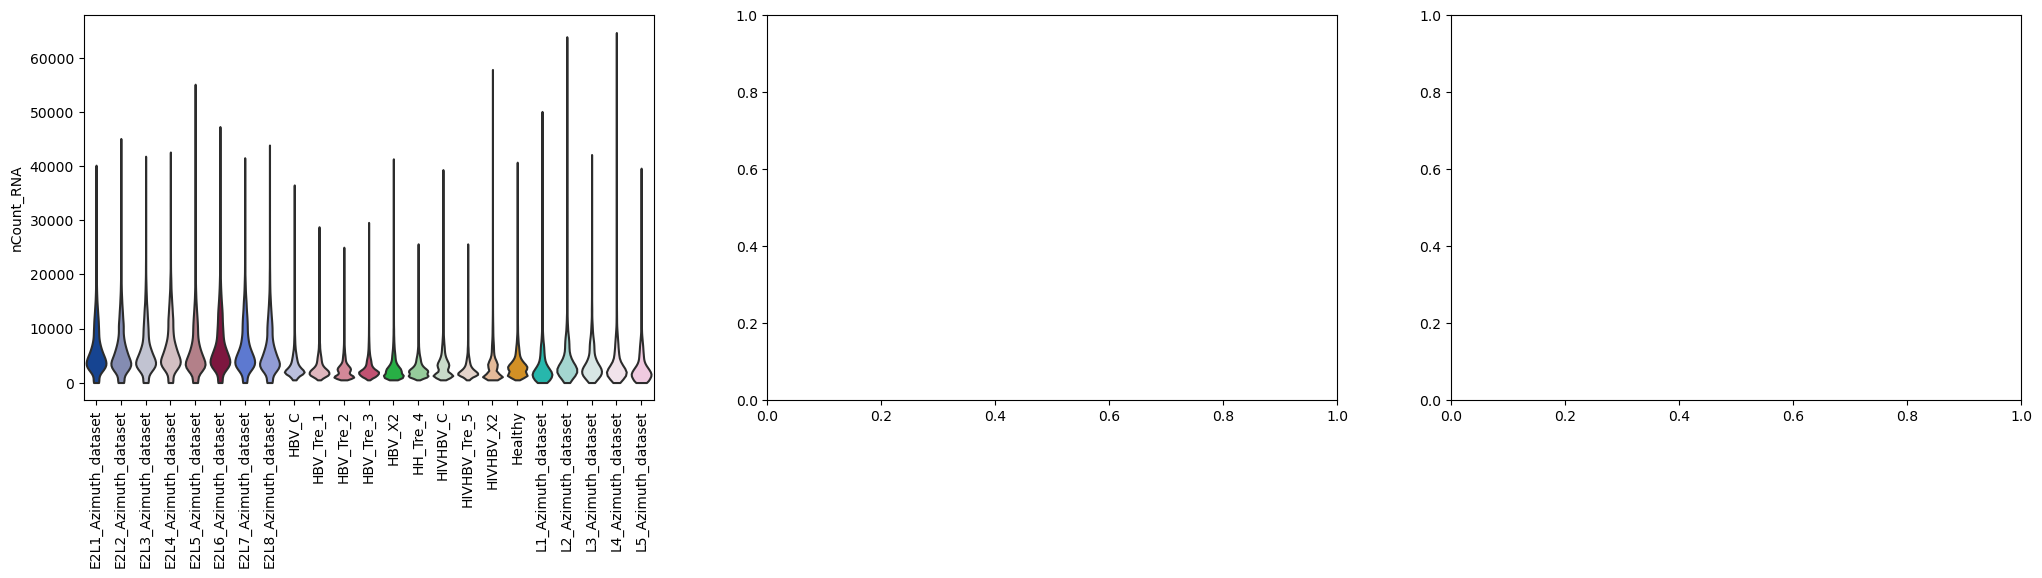

In [14]:
# Adjusted figure size for clarity
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
# Plots
sc.pl.violin(adata_concat, ['nCount_RNA'], groupby='sample_ID', stripplot=False, multi_panel=True, rotation=90, ax=ax1)
sc.pl.violin(adata_concat, ['nFeature_RNA'], groupby='sample_ID', stripplot=False, multi_panel=True, rotation=90, ax=ax2)
sc.pl.scatter(adata_concat, x='percent_ribo', y='percent_mito', size=3, color="sample_ID", ax=ax3)

fig.tight_layout(pad=1.0)


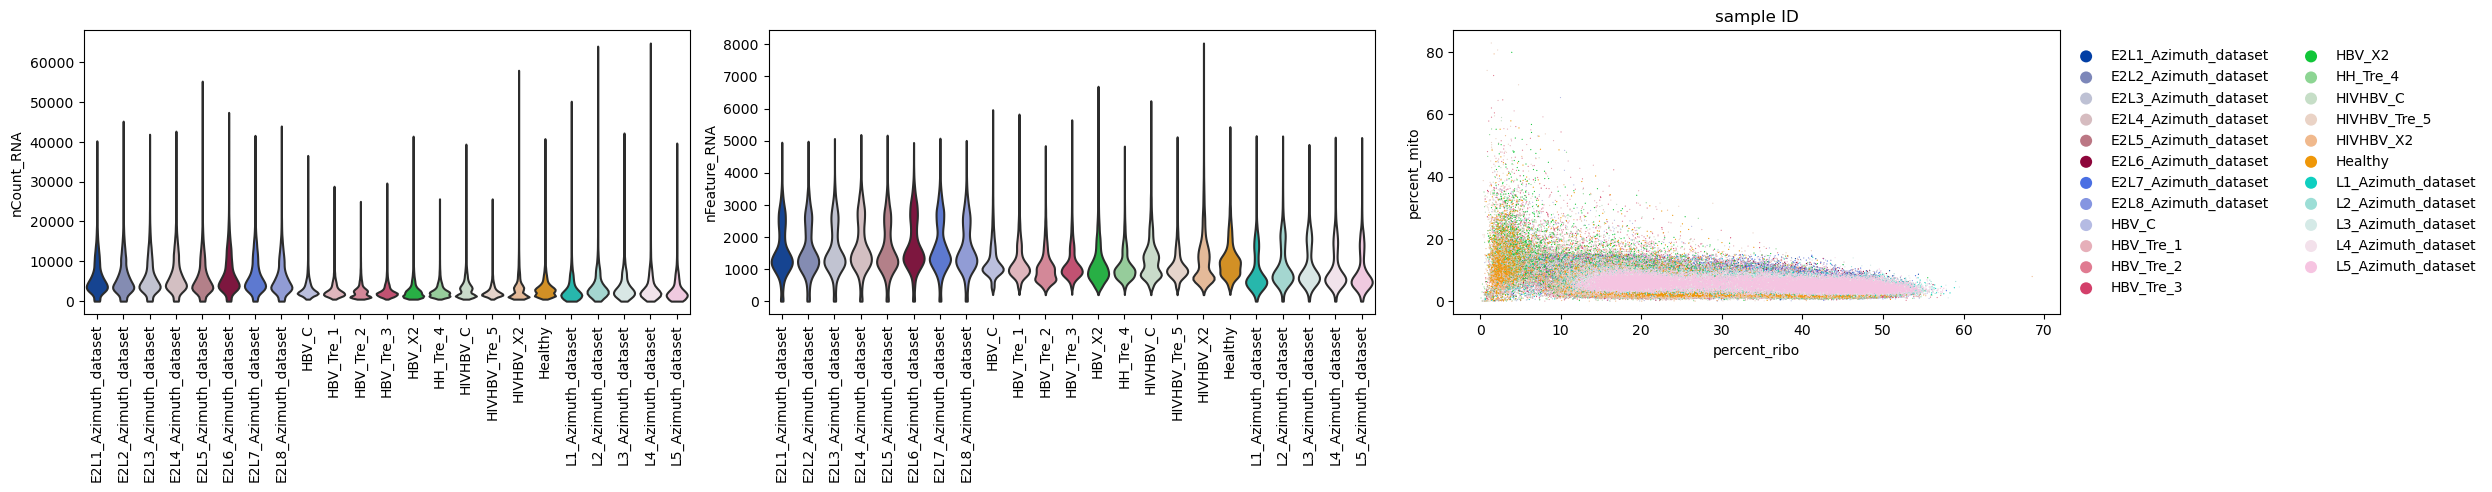

In [15]:
fig

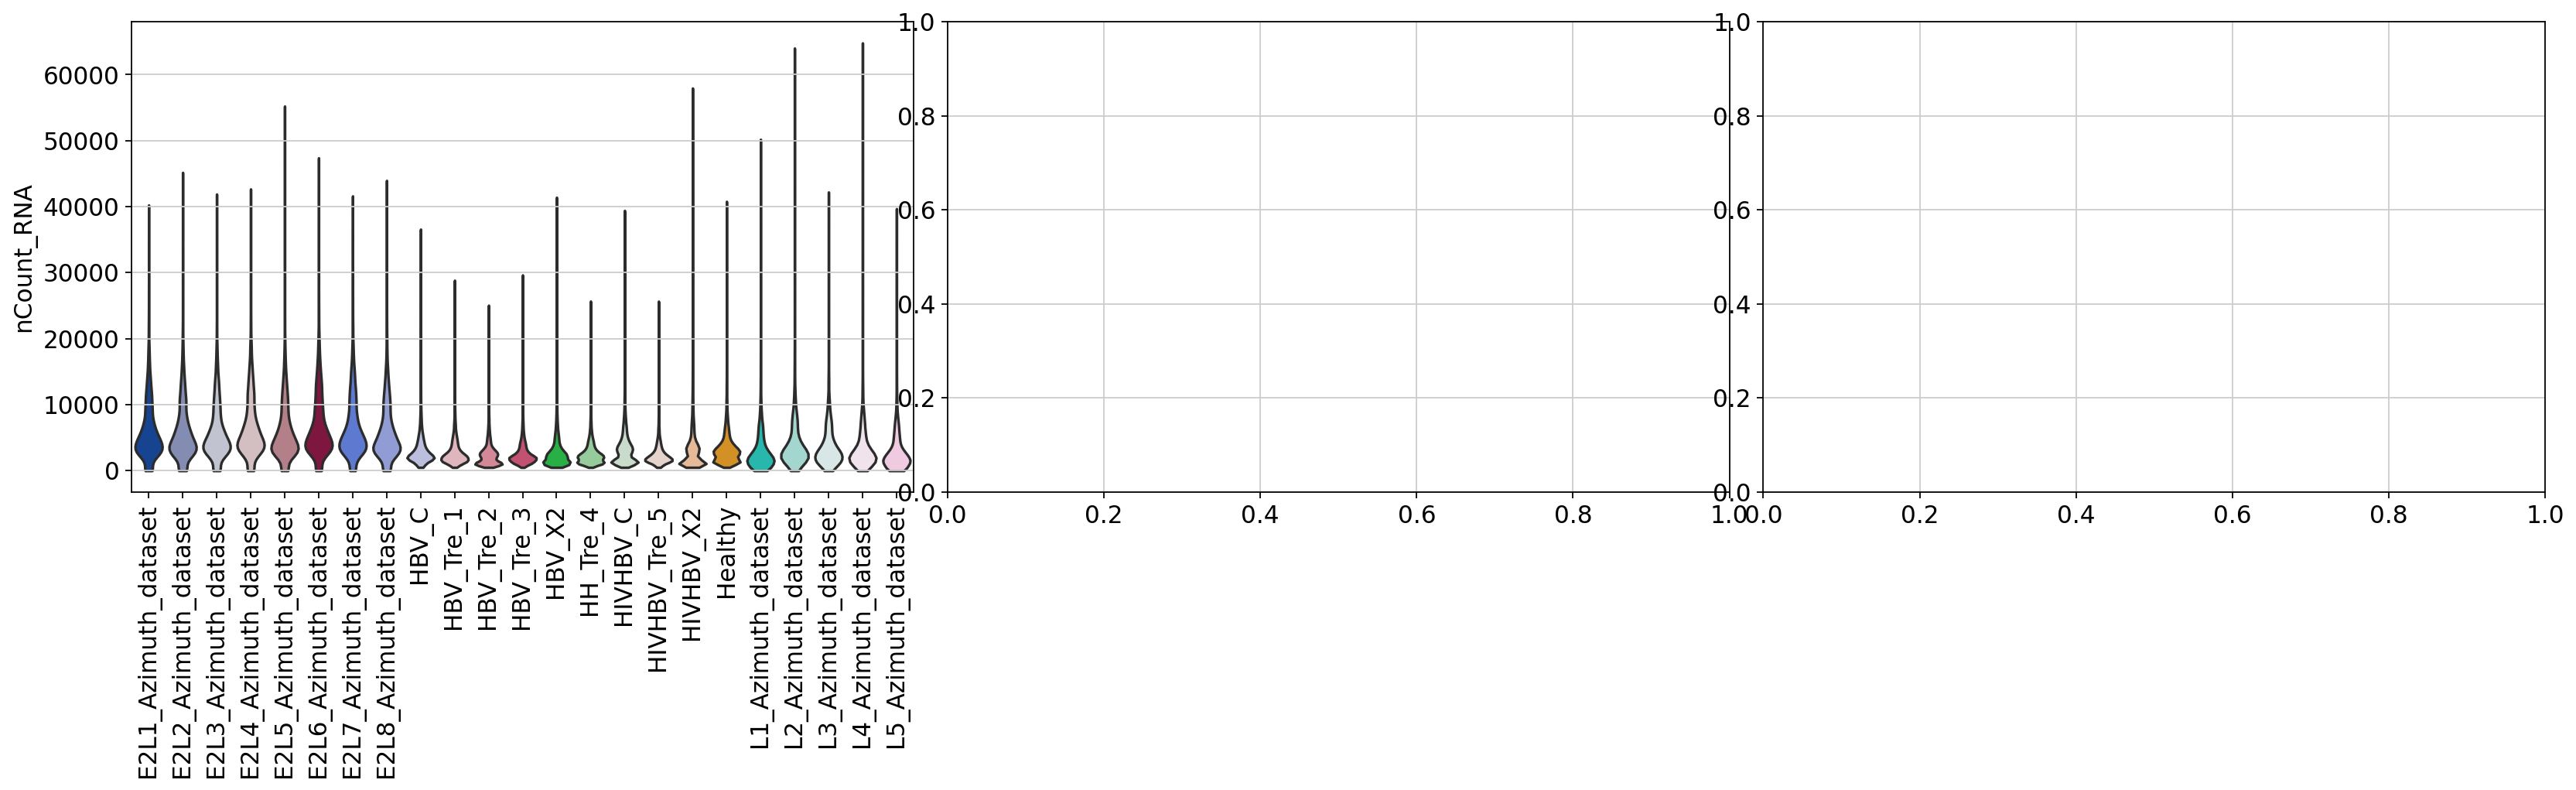

In [45]:
import matplotlib.gridspec as gridspec
# Create a figure with a custom GridSpec layout
sc.set_figure_params(vector_friendly=True, dpi_save=1000)

fig = plt.figure(figsize=(25, 5))
# Configure GridSpec: Assume 10 parts in total, ax1 and ax2 take 4 parts each, ax3 takes 2 parts
gs = gridspec.GridSpec(1, 12, figure=fig) 

# Assign axes
ax1 = fig.add_subplot(gs[0, :4])  # First four parts for ax1
ax2 = fig.add_subplot(gs[0, 4:8]) # Next four parts for ax2
ax3 = fig.add_subplot(gs[0, 8:]) 
# Plots
sc.pl.violin(adata_concat, ['nCount_RNA'], groupby='sample_ID', color = "Ref_lab", stripplot=False, multi_panel=True, rotation=90, ax=ax1)
sc.pl.violin(adata_concat, ['nFeature_RNA'], groupby='sample_ID', color = "Ref_lab", stripplot=False, multi_panel=True, rotation=90, ax=ax2)
sc.pl.scatter(adata_concat, x='percent_ribo', y='percent_mito', size=4, color="Ref_lab", ax=ax3)

fig.tight_layout(pad=1.0)


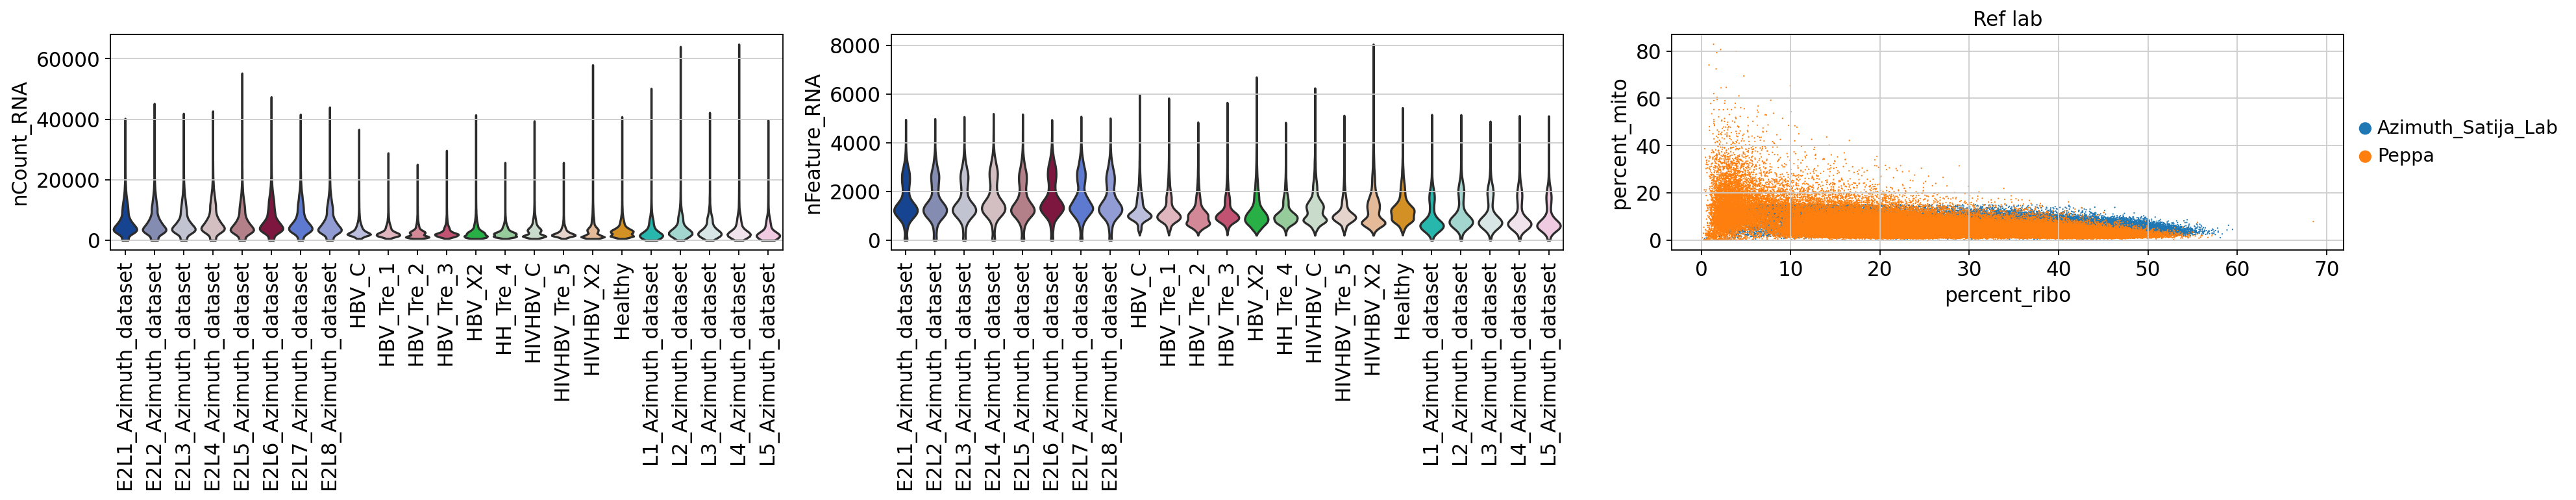

In [46]:
fig

In [18]:
fig.savefig("/well/immune-rep/users/vbw431/Projects/Peppa/notebooks/figures/QC_plot_revision.pdf")


In [19]:
from scipy.stats import kruskal
# Group the data by 'sample_ID' and create a list of 'nCounts_RNA' values for each group
groups = [adata_concat.obs['nCount_RNA'].values for name, group in adata_concat.obs.groupby('sample_ID')]

# Perform the Kruskal-Wallis test
stat, p = kruskal(*groups)

print(f'Kruskal-Wallis test statistic: {stat}')
print(f'P-value: {p}')

# Interpret the p-value
alpha = 0.05  # typically, a 5% level is chosen
if p < alpha:
    print('Reject the null hypothesis - suggest the distribution of nCounts_RNA is different across sample_ID groups')
else:
    print('Fail to reject the null hypothesis - suggest the distribution of nCounts_RNA is not significantly different across sample_ID groups')

Kruskal-Wallis test statistic: 7.450599362952506e-09
P-value: 1.0
Fail to reject the null hypothesis - suggest the distribution of nCounts_RNA is not significantly different across sample_ID groups


In [20]:
# Group the data by 'sample_ID' and create a list of 'nCounts_RNA' values for each group
groups = [adata_concat.obs['nFeature_RNA'].values for name, group in adata_concat.obs.groupby('sample_ID')]

# Perform the Kruskal-Wallis test
stat, p = kruskal(*groups)

print(f'Kruskal-Wallis test statistic: {stat}')
print(f'P-value: {p}')

# Interpret the p-value
alpha = 0.05  # typically, a 5% level is chosen
if p < alpha:
    print('Reject the null hypothesis - suggest the distribution of nCounts_RNA is different across sample_ID groups')
else:
    print('Fail to reject the null hypothesis - suggest the distribution of nCounts_RNA is not significantly different across sample_ID groups')

Kruskal-Wallis test statistic: 7.450584319098358e-09
P-value: 1.0
Fail to reject the null hypothesis - suggest the distribution of nCounts_RNA is not significantly different across sample_ID groups


In [21]:
##load data
adata = sc.read_h5ad("/well/immune-rep/users/vbw431/Projects/Peppa/out/peppa_azi_combat.h5ad")

labels = ["NK", "CD8", "CD4", "Bcells", "Myeloid_Plt"]
cluster_list = {}
scvi_list = {}
umap_list = {}
for i in [0,1,2,3,4]:
    print("reading in " + labels[i])
    cluster_list[labels[i]] = pd.read_csv(os.path.join(newdata_dir + labels[i] +"_clustering_final/", f"Peppa_{labels[i]}_cluster_assignment.csv"), index_col =0)
    scvi_list[labels[i]] = pd.read_csv(os.path.join(newdata_dir + labels[i] +"_embeddings/", f"Peppa_{labels[i]}_scvi.csv"), index_col =0)
    umap_list[labels[i]] = pd.read_csv(os.path.join(newdata_dir + labels[i] +"_embeddings/", f"Peppa_{labels[i]}_umap.csv"), index_col =0)

##generate adata_list
adata_list = {}

for i in [0,1,2,3, 4]:
    adata_list[labels[i]] = adata[cluster_list[labels[i]].index].copy()
    adata_list[labels[i]].obsm["X_scVI"] = scvi_list[labels[i]].loc[adata_list[labels[i]].obs_names].values
    adata_list[labels[i]].obsm["X_umap"] = umap_list[labels[i]].loc[adata_list[labels[i]].obs_names].values
    adata_list[labels[i]].obs = adata_list[labels[i]].obs.merge(cluster_list[labels[i]], left_index=True, right_index=True, how="inner")
    adata_list[labels[i]].layers['counts'] = adata_list[labels[i]].X.copy()
    sc.pp.normalize_total(adata_list[labels[i]], target_sum=1e4)
    sc.pp.log1p(adata_list[labels[i]])
    adata_list[labels[i]].layers['normalized'] = adata_list[labels[i]].X.copy()
    
##update meta_data with new clinical
clin_meta = pd.read_csv(newdata_dir + "index_demo.csv", index_col = 0)
clin_meta = clin_meta[["disease_group", 
                       "bio_replicate", 
                       "study_disease", 
                       "scanpy_index", 
                       "study_ID", 
                       "Treatment_status",
                      "Ethnicity",
                      "Sex",
                      "Age",
                      "HBV_serostatus",
                      "HBV_sAg_titre",
                      "HBV_DNA_VL"]]

new_obs = {}

for name in labels:
    del adata_list[name].obs["disease_group"]
    adata_list[name].obs["study_disease_orig"] = adata_list[name].obs["study_disease"].copy()
    del adata_list[name].obs["study_disease"]
    new_df = pd.merge(adata_list[name].obs, clin_meta, how='left', left_on = ['bio_replicate','scanpy_index'], right_on = ['bio_replicate','scanpy_index'])
    new_df.index = adata_list[name].obs.index
    new_obs[name] = new_df.copy()
    adata_list[name].obs = new_df.copy()

                 
for name in labels:
    adata_list[name].obs["celltype_consensus"] = str(name)

for name in labels:
    adata_list[name].obs["celltype_consensus.l1"] = str(name)
    adata_list[name].obs["celltype_consensus.l2"] = adata_list[name].obs[str(name+".annotation.l1")]
    adata_list[name].obs["celltype_consensus.l3"] = adata_list[name].obs[str(name+".annotation.l2")]
    
##concat
adata_all = anndata.concat(adata_list, join= "outer", index_unique=None)



reading in NK
reading in CD8
reading in CD4
reading in Bcells
reading in Myeloid_Plt


In [22]:
conditions = [
        (adata_all.obs["orig.ident"] == "SeuratProject"), 
        (adata_all.obs["orig.ident"] != "SeuratProject"), 
    ]
#create a list of the values we want to assign for each condition

values = [adata_all.obs["sample_ID"], adata_all.obs["lane"]]
    
adata_all.obs["sequencing_batch"] = np.select(conditions, values)



In [23]:
## HVG
#adata = adata[~adata.obs['celltype.l1'].isna(), :]

sc.pp.highly_variable_genes(
    adata_all,
    n_top_genes=3000,
    batch_key="sequencing_batch",
    flavor = "seurat_v3",
    subset=True)  

/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [24]:
sc.pp.normalize_total(adata_all, target_sum=1e4)


In [25]:
sc.pp.log1p(adata_all)


In [26]:
sc.tl.pca(adata_all, svd_solver='arpack')


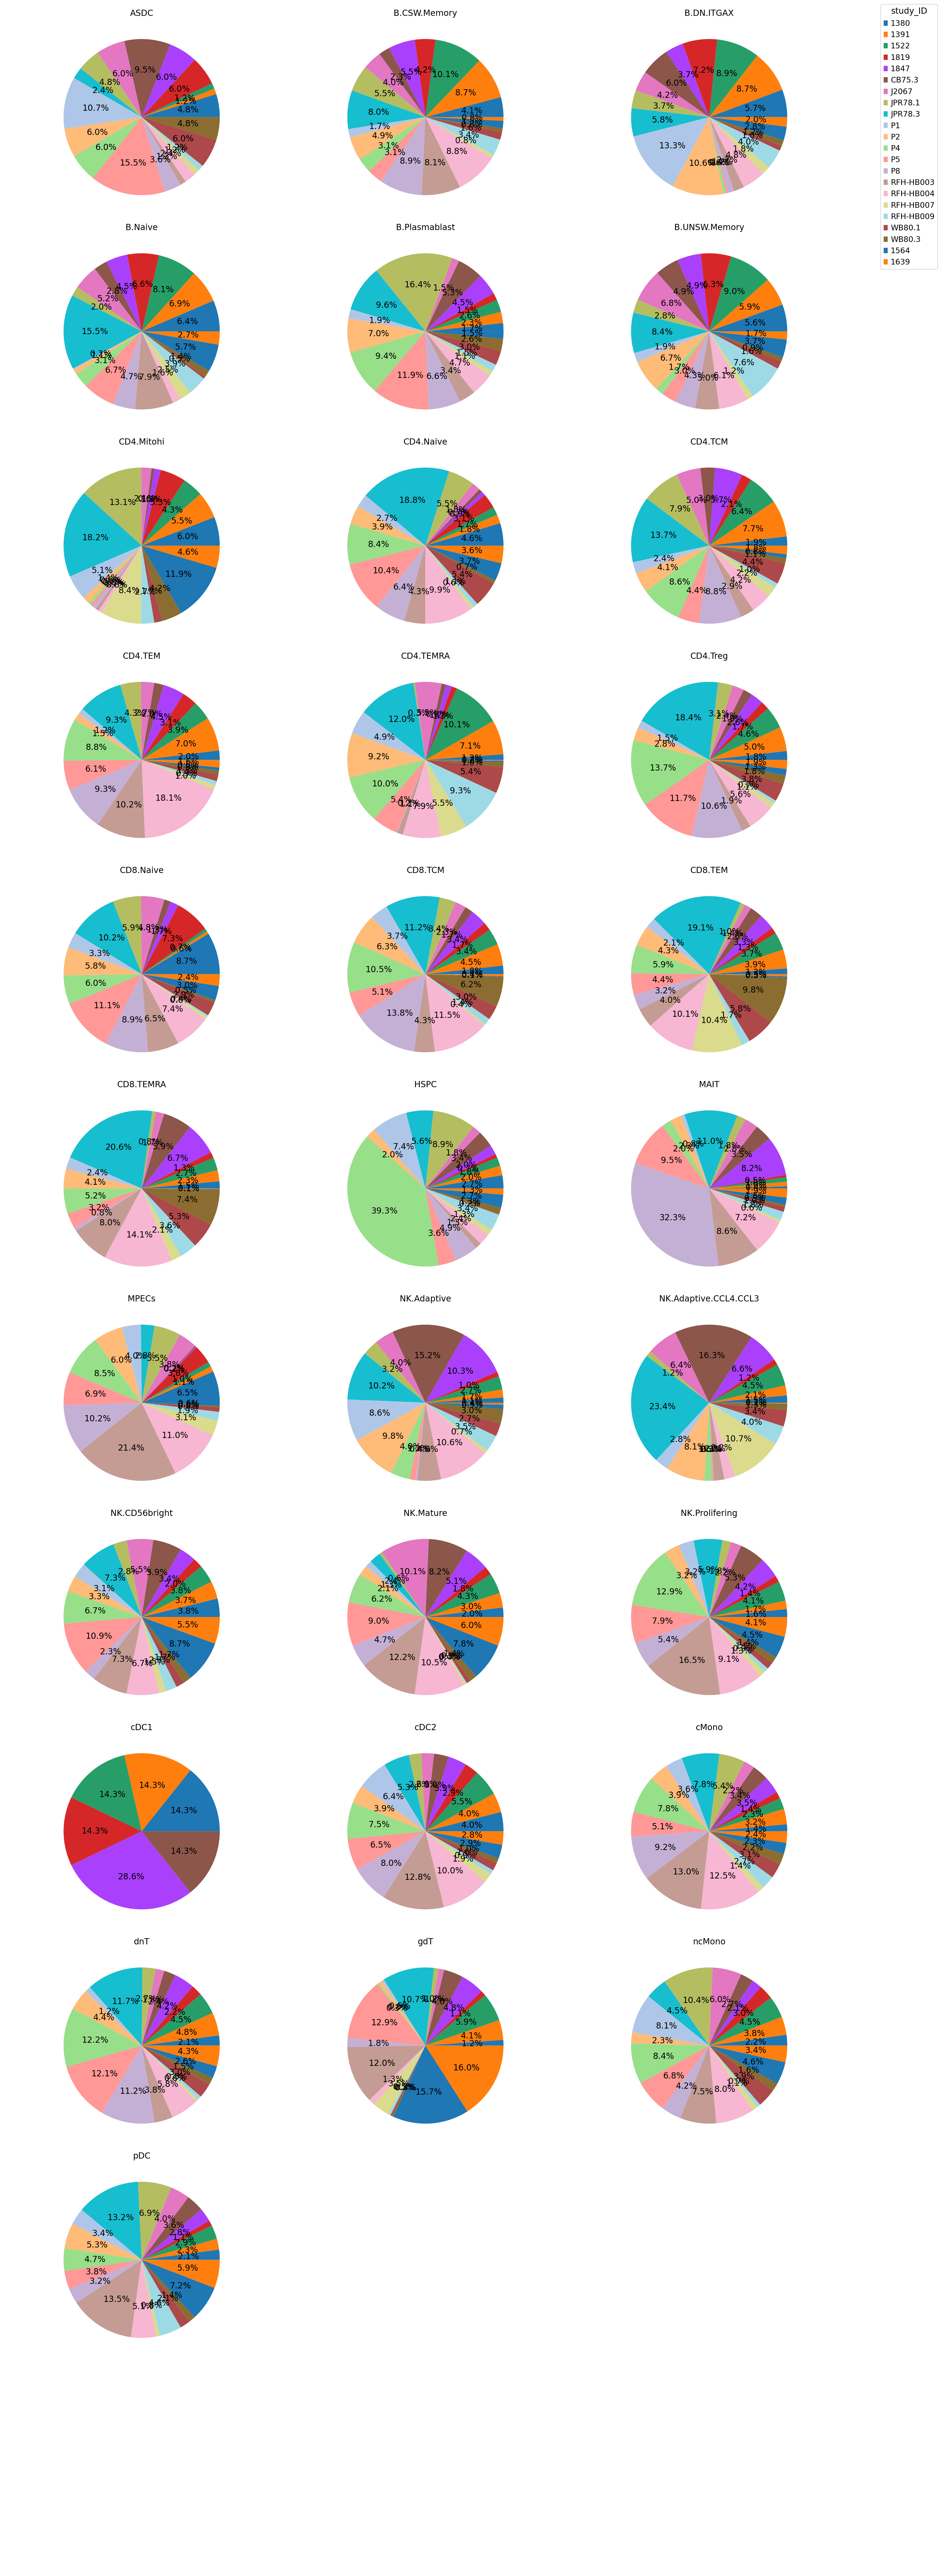

In [27]:
import math 

# Convert relevant data to a Pandas DataFrame
df = pd.DataFrame({
    'celltype_consensus.l2': adata_all.obs['celltype_consensus.l2'],
    'study_ID': adata_all.obs['study_ID']
})

# Drop rows with NA values in 'celltype_consensus.l2' or 'study_ID'
df.dropna(subset=['celltype_consensus.l2', 'study_ID'], inplace=True)

# Group by 'celltype_consensus.l2' and 'study_ID', then count occurrences
grouped = df.groupby(['celltype_consensus.l2', 'study_ID']).size().reset_index(name='counts')

# Get unique clusters
clusters = grouped['celltype_consensus.l2'].unique()

# Determine the number of rows and columns for the subplots
n_rows = 12
n_cols = math.ceil(len(clusters) / n_rows)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through each cluster and create a pie chart
for ax, cluster in zip(axes, clusters):
    # Filter data for the cluster
    cluster_data = grouped[grouped['celltype_consensus.l2'] == cluster]

    # Create pie chart
    wedges, _, _ = ax.pie(cluster_data['counts'], autopct='%1.1f%%')

    # Set title for each pie chart
    ax.set_title(cluster)

# Hide unused axes
for i in range(len(clusters), len(axes)):
    axes[i].axis('off')

# Create a joint legend
# Note: We're assuming 'study_ID' has the same categories across all clusters
legend_labels = grouped['study_ID'].unique()
fig.legend(wedges, legend_labels, loc='upper right', bbox_to_anchor=(1.1, 1), title="study_ID")

plt.tight_layout()
plt.show()

In [28]:
study_id_map = {
    "J2067": "Control 1",
    "CB75.3": "HBV-1",
    "JPR78.3": "HIV/HBV-5",
    "1639": "HBV-6",
    "1522": "HBV-4",
    "1819": "HBV-6",
    "1391": "HBV-4",
    "1847": "HBV-3",
    "RFH-HB007": "HIV/HBV-4",
    "JPR78.1": "HIV/HBV-5",
    "1380": "HBV-5",
    "WB80.1": "HBV-2",
    "1564": "HBV-5",
    "WB80.3": "HBV-2",
    "RFH-HB009": "HIV/HBV-2",
    "RFH-HB004": "HIV/HBV-1",
    "RFH-HB003": "HIV/HBV-3"
}

# Apply the mapping to create a new column
adata_all.obs['new_study_label'] = adata_all.obs['study_ID'].map(study_id_map)

# If there are any study_ID values that aren't in the mapping, they'll be NaN in 'new_study_label'
# You can fill them with the original values or some placeholder as needed
# For example, to keep original values where there's no mapping, use:
adata_all.obs['new_study_label'].fillna(adata_all.obs['bio_replicate'], inplace=True)

In [29]:
# Define a function that replaces 'P' with 'Azimuth P' if the value starts with 'P'
def replace_P_with_Azimuth_P(value):
    if pd.notna(value) and value.startswith('P'):
        return "Azimuth " + value
    else:
        return value

# Apply this function to the 'new_study_label' column
adata_all.obs['new_study_label'] = adata_all.obs['new_study_label'].apply(replace_P_with_Azimuth_P)

In [30]:
# Define the custom order for 'new_study_label'
order = [
    'Control 1','Azimuth P1', 'Azimuth P2', 'Azimuth P4', 'Azimuth P5', 
    'Azimuth P8', 'HBV-1', 'HBV-2', 'HBV-3', 'HBV-4', 'HBV-5', 'HBV-6', 
    'HIV/HBV-1', 'HIV/HBV-2', 'HIV/HBV-3', 'HIV/HBV-4', 'HIV/HBV-5'
]

# Convert the 'new_study_label' column to a Categorical type with the defined order
adata_all.obs['new_study_label'] = pd.Categorical(adata_all.obs['new_study_label'], categories=order, ordered=True)

# Now when you plot using this column, the values will appear in the defined order

/tmp/slurm-42304059/ipykernel_74346/2742345316.py:22: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = counts.pivot('new_study_label', 'celltype_consensus.l2', 'percentage')


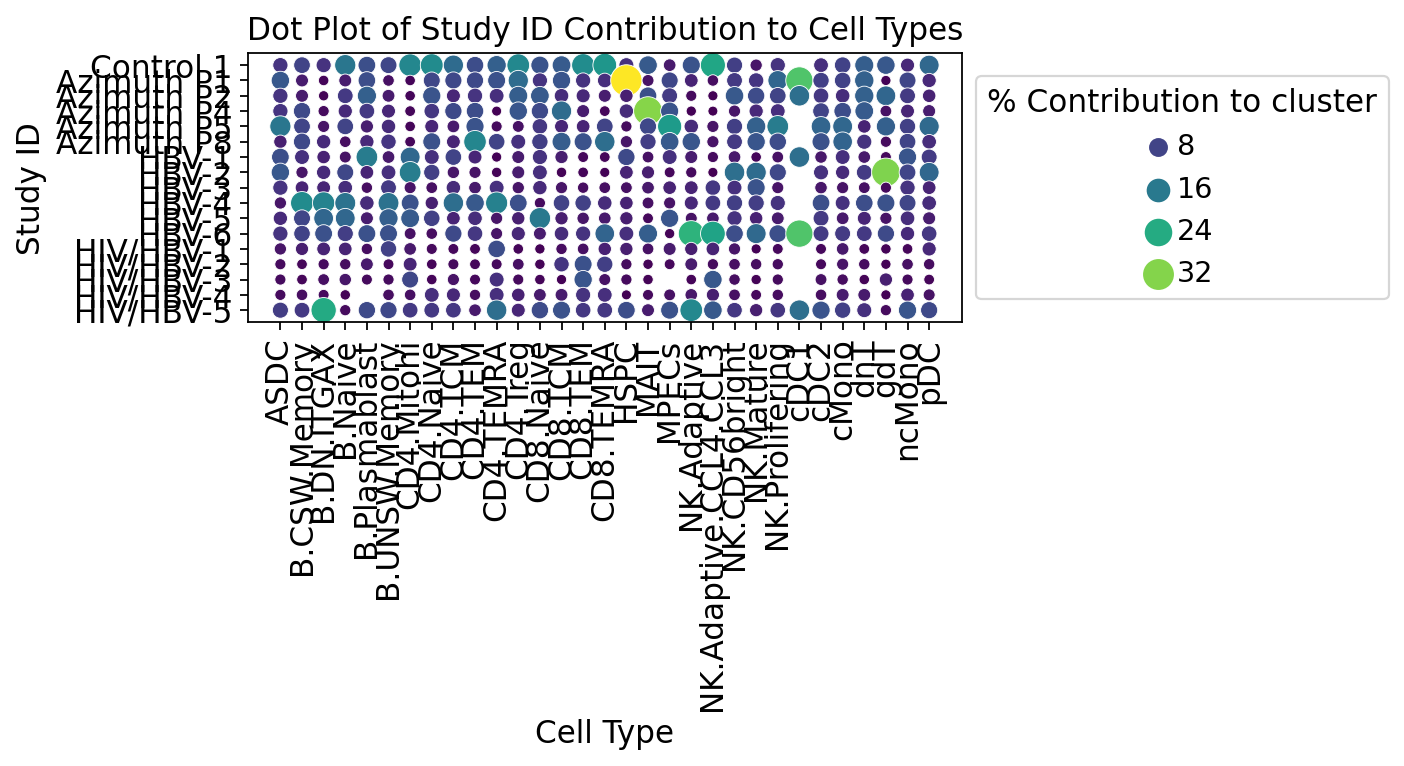

In [31]:
# Assuming 'adata_all' is your AnnData object

# Convert relevant data to a Pandas DataFrame
df = pd.DataFrame({
    'celltype_consensus.l2': adata_all.obs['celltype_consensus.l2'],
    'new_study_label': adata_all.obs['new_study_label']
})

# Group by 'celltype_consensus.l2' and 'study_ID', then count occurrences
counts = df.groupby(['celltype_consensus.l2', 'new_study_label']).size().reset_index(name='counts')

# Calculate total counts for each celltype_consensus.l2
total_counts = counts.groupby('celltype_consensus.l2')['counts'].sum().reset_index(name='total_counts')

# Merge to get total counts for each celltype
counts = counts.merge(total_counts, on='celltype_consensus.l2')

# Calculate percentage contribution
counts['percentage'] = (counts['counts'] / counts['total_counts']) * 100

# Pivot for plotting
pivot_df = counts.pivot('new_study_label', 'celltype_consensus.l2', 'percentage')

# Melt the DataFrame and filter out zero values
plot_data = pivot_df.melt(value_name='percentage', var_name='celltype_consensus.l2', ignore_index=False)
plot_data = plot_data[plot_data['percentage'] > 0]

# Create the dot plot using seaborn
plt.figure(figsize=(9, 5))
scatter = sns.scatterplot(data=plot_data, 
                          x='celltype_consensus.l2', y='new_study_label', size='percentage', sizes=(20, 200), 
                          hue='percentage', palette='viridis')

plt.xlabel('Cell Type')
plt.ylabel('Study ID')
plt.title('Dot Plot of Study ID Contribution to Cell Types')
scatter.legend(title='Percentage Contribution', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)

# Remove grid
plt.grid(False)

# Adjust legend for color scale
scatter.legend(title='% Contribution to cluster', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

plt.tight_layout()

plt.savefig('/well/immune-rep/users/vbw431/Projects/Peppa/notebooks/figures/cluster_dot_plot.pdf', bbox_inches='tight')

plt.show()

/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


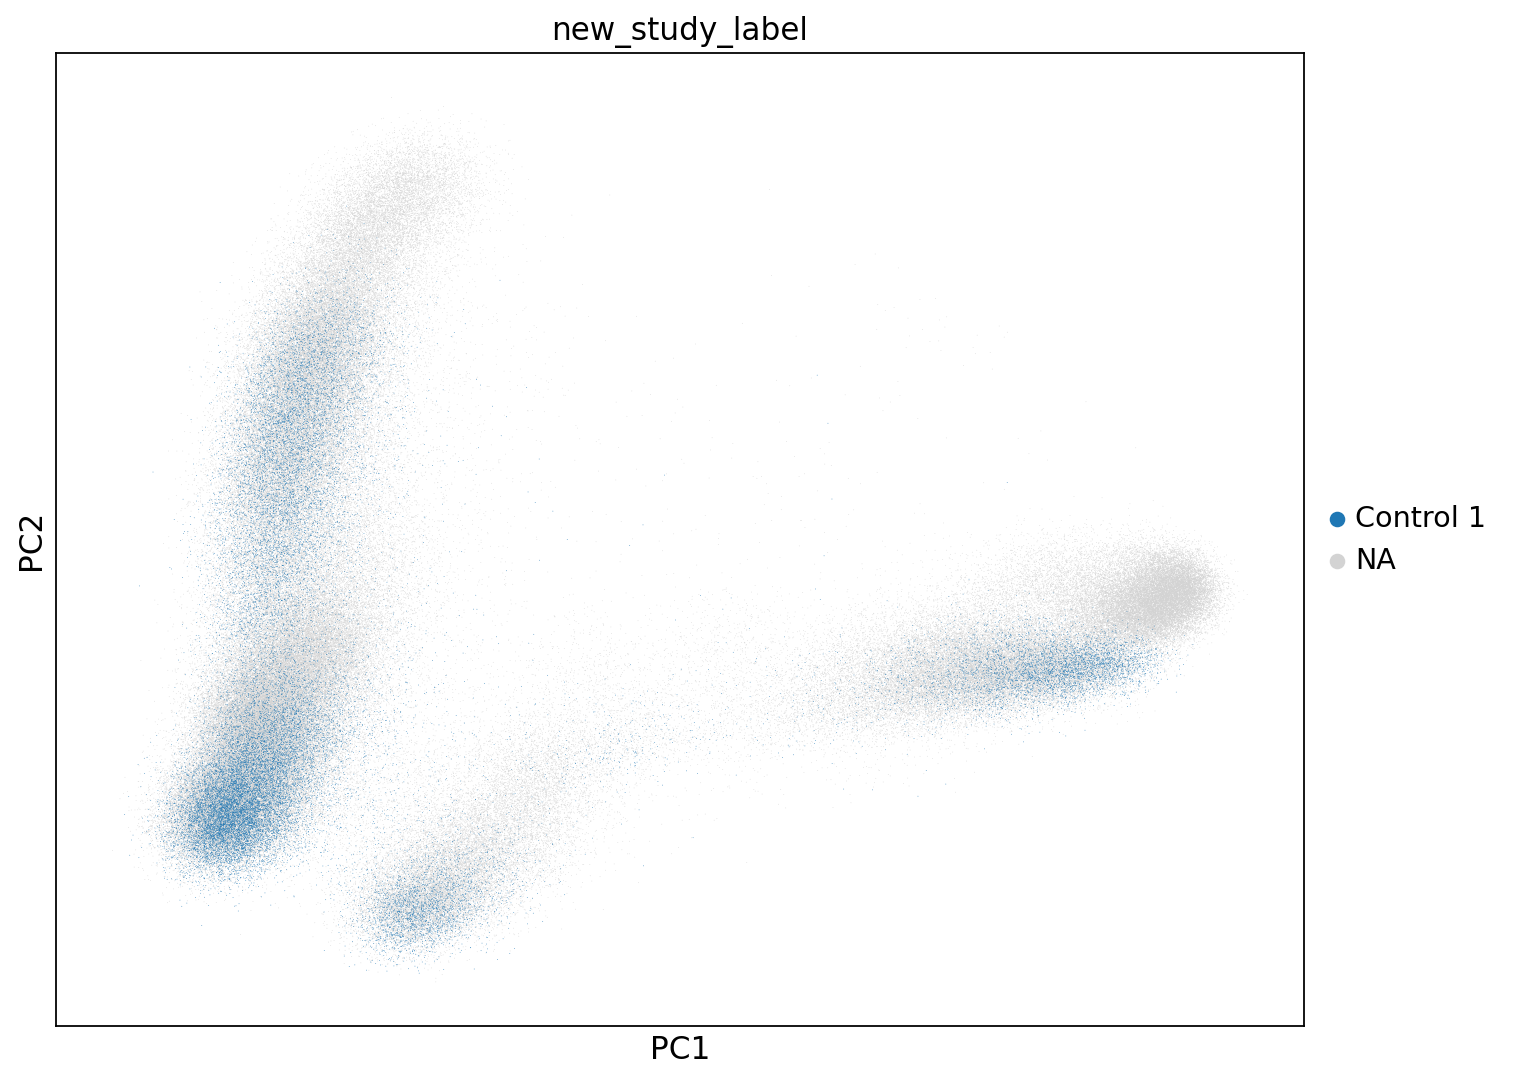

In [32]:
sc.pl.pca(adata_all, color='new_study_label', groups = ["Control 1"])


In [33]:
wang = sc.read_h5ad("/well/immune-rep/users/vbw431/Projects/Peppa/scvi/hiv_peppa_scvi/peppa_wang_annotated.h5ad")

/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/well/immune-rep/users/vbw431/conda/skylake/envs/scvi_tools_gpu/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


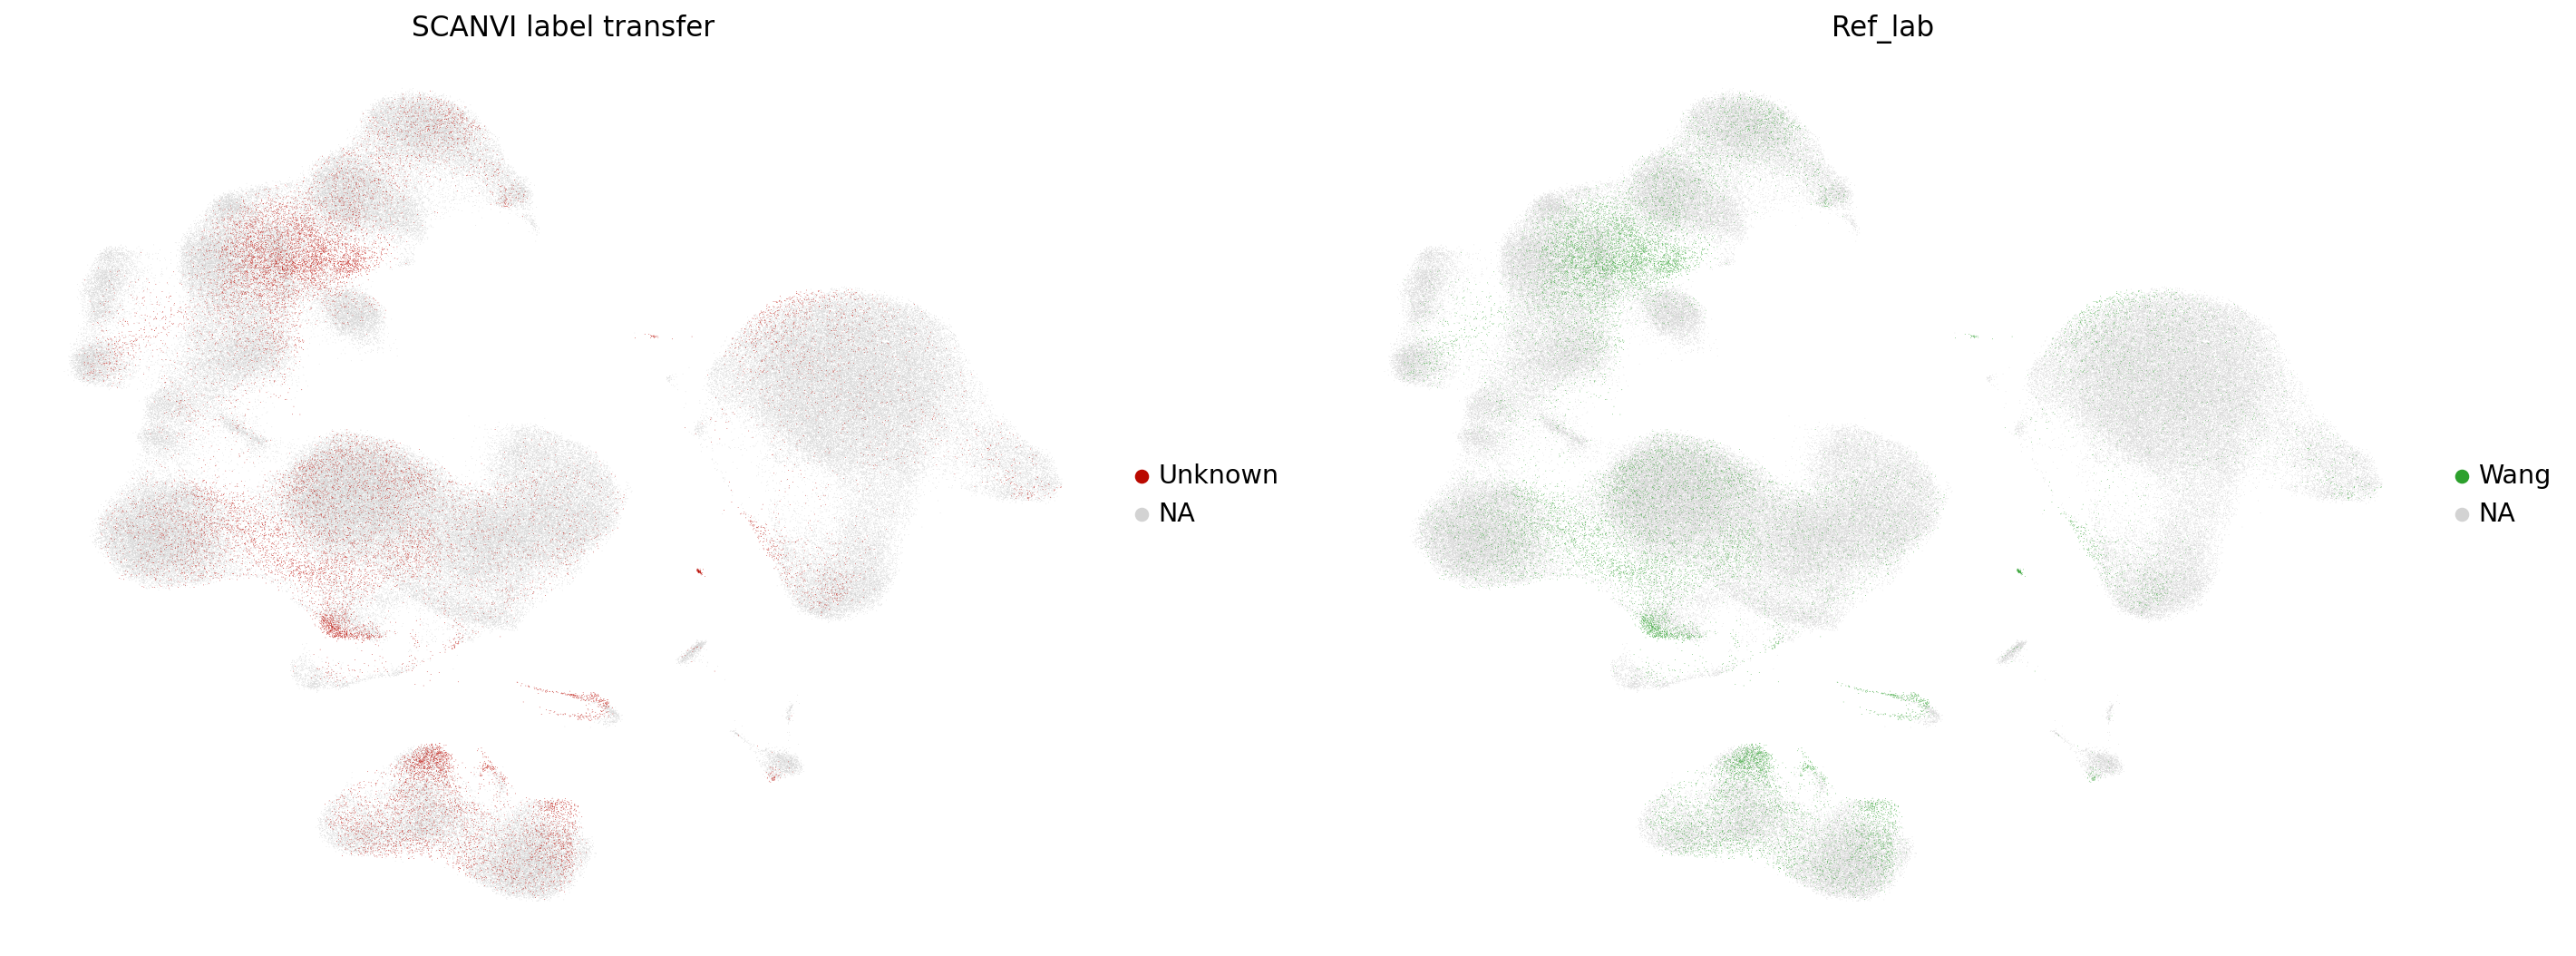

In [38]:
wang.obs["SCANVI label transfer"] = wang.obs["celltype_consensus.l2"]
wang.obs['Ref_lab']= wang.obs['Ref_lab'].fillna("Peppa")

sc.pl.umap(
    wang,
    color=["SCANVI label transfer", "Ref_lab"],
    groups = ["Unknown", "Wang"],
    frameon=False,
    ncols=2,
    save='wang_umap.pdf'
)


In [37]:
set(wang.obs)

{'ART_therapy',
 'Age',
 'Bcells.annotation.l1',
 'Bcells.annotation.l2',
 'CD4.annotation.l1',
 'CD4.annotation.l2',
 'CD4_count_cells_ul',
 'CD8.annotation.l1',
 'CD8.annotation.l2',
 'CITE_present',
 'CMV_status',
 'C_scANVI',
 'Classification',
 'Donor_ID',
 'Duration_infection_years',
 'Ethnicity',
 'G2M.Score',
 'GEO_ID',
 'HBV_DNA_VL',
 'HBV_sAg_titre',
 'HBV_serostatus',
 'HTO_classification',
 'HTO_classification.global',
 'HTO_margin',
 'HTO_maxID',
 'HTO_secondID',
 'Hashtag.1',
 'Hashtag.2',
 'Infection_stage',
 'Myeloid_Plt.annotation.l1',
 'Myeloid_Plt.annotation.l2',
 'NK.annotation.l1',
 'NK.annotation.l2',
 'Number.proteins.detected',
 'Phase',
 'PlasmaHIVRNA_copies_ml',
 'Protein.log.library.size',
 'QC_label',
 'RNA.log.library.size',
 'Ref_lab',
 'S.Score',
 'SCANVI label transfer',
 'Sex',
 'Suppresion',
 'Treatment_status',
 'X_index',
 '_scvi_batch',
 '_scvi_labels',
 'batch',
 'bio_replicate',
 'celltype.l1',
 'celltype.l2',
 'celltype.l3',
 'celltype_consensus.